In [1]:
%matplotlib inline


# Linear classifier on sensor data with plot patterns and filters


Decoding, a.k.a MVPA or supervised machine learning applied to MEG and EEG
data in sensor space. Fit a linear classifier with the LinearModel object
providing topographical patterns which are more neurophysiologically
interpretable [1]_ than the classifier filters (weight vectors).
The patterns explain how the MEG and EEG data were generated from the
discriminant neural sources which are extracted by the filters.
Note patterns/filters in MEG data are more similar than EEG data
because the noise is less spatially correlated in MEG than EEG.

References
----------

.. [1] Haufe, S., Meinecke, F., Görgen, K., Dähne, S., Haynes, J.-D.,
       Blankertz, B., & Bießmann, F. (2014). On the interpretation of
       weight vectors of linear models in multivariate neuroimaging.
       NeuroImage, 87, 96–110. doi:10.1016/j.neuroimage.2013.10.067



In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Romain Trachel <trachelr@gmail.com>
#          Jean-Remi King <jeanremi.king@gmail.com>
#
# License: BSD (3-clause)

import mne
from mne import io, EvokedArray
from mne.datasets import sample
from mne.decoding import Vectorizer, get_coef

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# import a linear classifier from mne.decoding
from mne.decoding import LinearModel

print(__doc__)

data_path = sample.data_path()

Automatically created module for IPython interactive environment


Set parameters



In [4]:
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
# /home/arasdar/mne_data/MNE-sample-data
tmin, tmax = -0.1, 0.4
event_id = dict(aud_l=1, vis_l=3)

# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname, preload=True)
raw.filter(.5, 25)
events = mne.read_events(event_fname)

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    decim=4, baseline=None, preload=True)

labels = epochs.events[:, -1]

# get MEG and EEG data
meg_epochs = epochs.copy().pick_types(meg=True, eeg=False)
meg_data = meg_epochs.get_data().reshape(len(labels), -1)

Opening raw data file /home/arasdar/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Setting up band-pass filter from 0.5 - 25 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 1982 samples (13.200 sec) selected
145 matching events found
The measurement information indicates a low-pass frequency of 25 Hz. The decim=4 parameter will result in a sampling frequency of 37.5384 Hz, which can cause aliasing artifacts.
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 145 events and 76 original time points ...


<ipython-input-4-77a363bee52c>:14: RuntimeWarning: The measurement information indicates a low-pass frequency of 25 Hz. The decim=4 parameter will result in a sampling frequency of 37.5384 Hz, which can cause aliasing artifacts.
  decim=4, baseline=None, preload=True)


0 bad epochs dropped


Decoding in sensor space using a LogisticRegression classifier



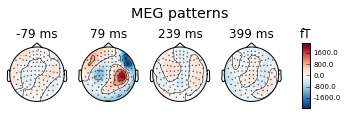

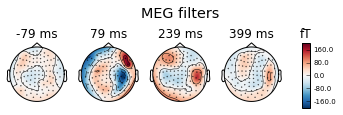

In [5]:
clf = LogisticRegression()
scaler = StandardScaler()

# create a linear model with LogisticRegression
model = LinearModel(clf)

# fit the classifier on MEG data
X = scaler.fit_transform(meg_data)
model.fit(X, labels)

# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(meg_epochs.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, meg_epochs.info, tmin=epochs.tmin)
    evoked.plot_topomap(title='MEG %s' % name)

Let's do the same on EEG data using a scikit-learn pipeline



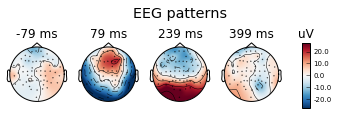

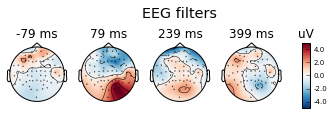

In [6]:
X = epochs.pick_types(meg=False, eeg=True)
y = epochs.events[:, 2]

# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
    StandardScaler(),                   # 2) normalize features across trials
    LinearModel(LogisticRegression()))  # 3) fits a logistic regression
clf.fit(X, y)

# Extract and plot patterns and filters
for name in ('patterns_', 'filters_'):
    # The `inverse_transform` parameter will call this method on any estimator
    # contained in the pipeline, in reverse order.
    coef = get_coef(clf, name, inverse_transform=True)
    evoked = EvokedArray(coef, epochs.info, tmin=epochs.tmin)
    evoked.plot_topomap(title='EEG %s' % name[:-1])